# Scattering Matrix Plugin

Run this notebook in your browser using [Binder](https://mybinder.org/v2/gh/flexcompute-readthedocs/tidy3d-docs/readthedocs?labpath=docs%2Fsource%2Fnotebooks%2FSMatrix.ipynb).

This notebook will give a demo of the tidy3d [ComponentModeler](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.plugins.ComponentModeler.html) plugin used to compute scattering matrix elements.

In [1]:
# make sure notebook plots inline
%matplotlib inline

# standard python imports
import numpy as np
import matplotlib.pyplot as plt
import os
import gdspy

# tidy3D imports
import tidy3d as td
from tidy3d import web

# set tidy3d to only print error information to reduce verbosity
td.logging_level = 'error'

## Setup

We will simulate a directional coupler, similar to the GDS and Parameter scan tutorials.

Let's start by setting up some basic parameters.

In [2]:
# wavelength / frequency
lambda0 = 1.550                     # all length scales in microns
freq0 = td.constants.C_0 / lambda0
fwidth = freq0 / 10

# Spatial grid specification
grid_spec = td.GridSpec.auto(min_steps_per_wvl=14, wavelength=lambda0)

# Permittivity of waveguide and substrate
wg_n = 3.48
sub_n = 1.45
mat_wg = td.Medium(permittivity=wg_n**2)
mat_sub = td.Medium(permittivity=sub_n**2)

# Waveguide dimensions

# Waveguide height
wg_height = 0.22
# Waveguide width
wg_width = 1.0
# Waveguide separation in the beginning/end
wg_spacing_in = 8
# length of coupling region (um)
coup_length = 6.0
# spacing between waveguides in coupling region (um)
wg_spacing_coup = 0.05
# Total device length along propagation direction
device_length = 100
# Length of the bend region
bend_length = 16
# Straight waveguide sections on each side
straight_wg_length = 4
# space between waveguide and PML
pml_spacing = 2

### Define waveguide bends and coupler

Here is where we define our directional coupler shape programmatically in terms of the geometric parameters

In [3]:
def bend_pts(bend_length, width, npts=10):
    """ Set of points describing a tanh bend from (0, 0) to (length, width)"""
    x = np.linspace(0, bend_length, npts)
    y = width*(1 + np.tanh(6*(x/bend_length - 0.5)))/2
    return np.stack((x, y), axis=1)

def arm_pts(length, width, coup_length, bend_length, npts_bend=30):
    """ Set of points defining one arm of an integrated coupler """
    ### Make the right half of the coupler arm first
    # Make bend and offset by coup_length/2
    bend = bend_pts(bend_length, width, npts_bend)
    bend[:, 0] += coup_length / 2
    # Add starting point as (0, 0)
    right_half = np.concatenate(([[0, 0]], bend))
    # Add an extra point to make sure waveguide is straight past the bend
    right_half = np.concatenate((right_half, [[right_half[-1, 0] + 0.1, width]]))
    # Add end point as (length/2, width)
    right_half = np.concatenate((right_half, [[length/2, width]]))

    # Make the left half by reflecting and omitting the (0, 0) point
    left_half = np.copy(right_half)[1:, :]
    left_half[:, 0] = -left_half[::-1, 0]
    left_half[:, 1] = left_half[::-1, 1]
    
    return np.concatenate((left_half, right_half), axis=0)

def make_coupler(
    length, 
    wg_spacing_in,
    wg_width,
    wg_spacing_coup,
    coup_length,
    bend_length,
    npts_bend=30):
    """ Make an integrated coupler using the gdspy FlexPath object. """

    # Compute one arm of the coupler
    arm_width = (wg_spacing_in - wg_width - wg_spacing_coup)/2
    arm = arm_pts(length, arm_width, coup_length, bend_length, npts_bend)
    # Reflect and offset bottom arm
    coup_bot = np.copy(arm)
    coup_bot[:, 1] = -coup_bot[::-1, 1] - wg_width/2 - wg_spacing_coup/2
    # Offset top arm
    coup_top = np.copy(arm)
    coup_top[:, 1] += wg_width/2 + wg_spacing_coup/2
    
    # Create waveguides as GDS paths
    path_bot = gdspy.FlexPath(coup_bot, wg_width, layer=1, datatype=0)
    path_top = gdspy.FlexPath(coup_top, wg_width, layer=1, datatype=1)
    
    return [path_bot, path_top]

### Create Base Simulation

The scattering matrix tool requires the "base" [Simulation](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.Simulation.html) (without the modal sources or monitors used to compute S-parameters), so we will construct that now.

We generate the structures and add a [FieldMonitor](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.FieldMonitor.html?highlight=FieldMonitor) so we can inspect the field patterns.

In [4]:
gdspy.current_library = gdspy.GdsLibrary()
lib = gdspy.GdsLibrary()

# Geometry must be placed in GDS cells to import into Tidy3D
coup_cell = lib.new_cell('Coupler')

substrate = gdspy.Rectangle(
    (-device_length/2, -wg_spacing_in/2-10),
    (device_length/2, wg_spacing_in/2+10),
    layer=0)
coup_cell.add(substrate)

# Add the coupler to a gdspy cell
gds_coup = make_coupler(
    device_length,
    wg_spacing_in,
    wg_width,
    wg_spacing_coup,
    coup_length,
    bend_length)
coup_cell.add(gds_coup)

# Substrate
[oxide_geo] = td.PolySlab.from_gds(
    gds_cell=coup_cell,
    gds_layer=0,
    gds_dtype=0,
    slab_bounds=(-10, 0),
    axis=2)

oxide = td.Structure(
    geometry=oxide_geo,
    medium=mat_sub)

# Waveguides (import all datatypes if gds_dtype not specified)
coupler1_geo, coupler2_geo = td.PolySlab.from_gds(
    gds_cell=coup_cell,
    gds_layer=1,
    slab_bounds=(0, wg_height),
    axis=2)

coupler1 = td.Structure(
    geometry=coupler1_geo,
    medium=mat_wg
)

coupler2 = td.Structure(
    geometry=coupler2_geo,
    medium=mat_wg
)

# Simulation size along propagation direction
sim_length = 2*straight_wg_length + 2*bend_length + coup_length

# Spacing between waveguides and PML
sim_size = [
    sim_length,
    wg_spacing_in + wg_width + 2*pml_spacing,
    wg_height + 2*pml_spacing]

# source
src_pos = sim_length/2 - straight_wg_length/2

# in-plane field monitor (optional, increases required data storage)
domain_monitor = td.FieldMonitor(
    center = [0,0,wg_height/2],
    size = [td.inf, td.inf, 0],
    freqs = [freq0],
    name='field'
)

# initialize the simulation
sim = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    structures=[oxide, coupler1, coupler2],
    sources=[],
    monitors=[domain_monitor],
    run_time=50/fwidth,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML())
)


[16:15:00] WARNING  No sources in simulation.                               ]8;id=114047;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=583776;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#406\406]8;;\

<Figure size 1080x720 with 2 Axes>

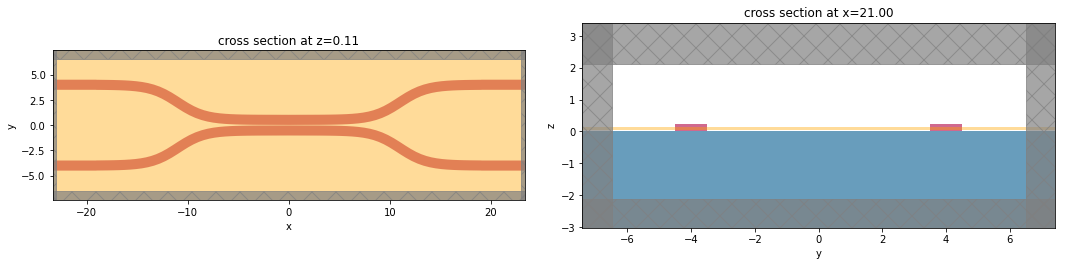

In [5]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(15, 10))
ax1 = sim.plot(z=wg_height/2, ax=ax1)
ax2 = sim.plot(x=src_pos, ax=ax2)

## Setting up Scattering Matrix Tool
Now, to use the S matrix tool, we need to defing the spatial extent of the "ports" of our system using [Port](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.plugins.Port.html) objects.

These ports will be converted into modal sources and monitors later, so they require both some mode specification and a definition of the direction that points into the system.

We'll also give them names to refer to later.

In [6]:
from tidy3d.plugins.smatrix.smatrix import Port

port_right_top = Port(
    center=[src_pos, wg_spacing_in / 2, wg_height / 2],
    size=[0, 4, 2],
    mode_spec=td.ModeSpec(num_modes=2),
    direction='-',
    name='right_top')

port_right_bot = Port(
    center=[src_pos, -wg_spacing_in / 2, wg_height / 2],
    size=[0, 4, 2],
    mode_spec=td.ModeSpec(num_modes=2),
    direction='-',
    name='right_bot')

port_left_top = Port(
    center=[-src_pos, wg_spacing_in / 2, wg_height / 2],
    size=[0, 4, 2],
    mode_spec=td.ModeSpec(num_modes=2),
    direction='+',
    name='left_top')

port_left_bot = Port(
    center=[-src_pos, -wg_spacing_in / 2, wg_height / 2],
    size=[0, 4, 2],
    mode_spec=td.ModeSpec(num_modes=2),
    direction='+',
    name='left_bot')

ports = [port_right_top, port_right_bot, port_left_top, port_left_bot]

Next, we will add the base simulation and ports to the [ComponentModeler](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.plugins.ComponentModeler.html), along with the frequency of interest and a name for saving the batch of simulations that will get created later.

In [11]:
from tidy3d.plugins.smatrix.smatrix import ComponentModeler
modeler = ComponentModeler(simulation=sim, ports=ports, freq=freq0)

[16:21:11] INFO     Uploaded task 'smatrix_portright_top_mode0' with task_id    ]8;id=62258;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=911352;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#120\120]8;;\
                    '04bc5182-b27e-4a34-a618-1a123bb6bc89'.                                  

Output()

[16:21:12] INFO     Uploaded task 'smatrix_portright_top_mode1' with task_id    ]8;id=55961;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=400165;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#120\120]8;;\
                    'ff71c50e-9310-4e63-8968-7cba33edf759'.                                  

Output()

[16:21:13] INFO     Uploaded task 'smatrix_portright_bot_mode0' with task_id    ]8;id=724046;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=921381;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#120\120]8;;\
                    '3191d59d-8fc1-4179-b9af-0f3d66c2f3b9'.                                  

Output()

[16:21:15] INFO     Uploaded task 'smatrix_portright_bot_mode1' with task_id    ]8;id=703195;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=825404;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#120\120]8;;\
                    'a4995ddd-aa9b-4024-bf3b-2d91cf96b058'.                                  

Output()

[16:21:16] INFO     Uploaded task 'smatrix_portleft_top_mode0' with task_id     ]8;id=344449;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=915672;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#120\120]8;;\
                    '5bc5306b-1439-439a-8584-38e8f7c01fcc'.                                  

Output()

[16:21:18] INFO     Uploaded task 'smatrix_portleft_top_mode1' with task_id     ]8;id=141975;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=781390;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#120\120]8;;\
                    '324b3fa4-516e-41da-bc99-706c4d5ad8ae'.                                  

Output()

[16:21:19] INFO     Uploaded task 'smatrix_portleft_bot_mode0' with task_id     ]8;id=148192;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=488076;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#120\120]8;;\
                    'a59704b1-cd3e-4872-af50-46a275cac831'.                                  

Output()

[16:21:21] INFO     Uploaded task 'smatrix_portleft_bot_mode1' with task_id     ]8;id=829495;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=826258;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#120\120]8;;\
                    '7f2cab86-92b2-4a9b-9b95-4f8844cde986'.                                  

Output()

We can plot the simulation with all of the ports as sources to check things are set up correctly.

[16:21:25] WARNING  No sources in simulation.                               ]8;id=156423;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=753778;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#406\406]8;;\

           WARNING  No sources in simulation.                               ]8;id=908763;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=542995;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#406\406]8;;\

<Figure size 1080x720 with 2 Axes>

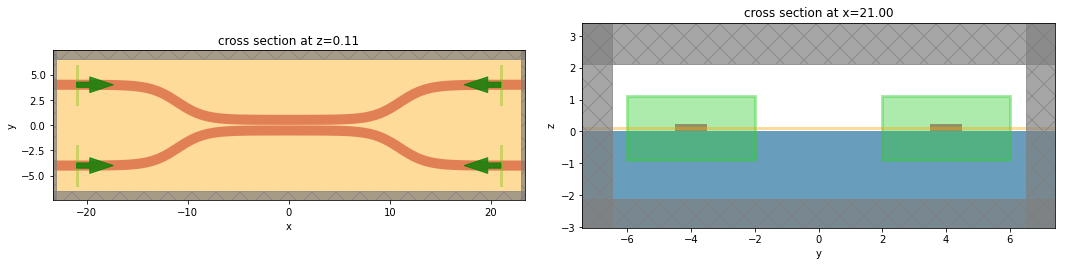

In [12]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(15, 10))
ax1 = modeler.plot_sim(z=wg_height/2, ax=ax1)
ax2 = modeler.plot_sim(x=src_pos, ax=ax2)

## Solving for the S matrix

With the component modeler defined, we may call it's `.solve()` method to run a batch of simulations to compute the S matrix.
The tool will loop through each port and create one simulation per mode index (as defined by the mode specifications) where a unique modal source is injected.
Each of the ports will also be converted to mode monitors to measure the mode amplitudes and normalization.

In [13]:
smatrix = modeler.run(path_dir='data')

[16:21:46] Started working on Batch.                                         ]8;id=252623;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/container.py\container.py]8;;\:]8;id=469939;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/container.py#384\384]8;;\

Output()

[16:24:49] Batch complete.                                                   ]8;id=654025;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/container.py\container.py]8;;\:]8;id=223821;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/container.py#405\405]8;;\

[16:24:50] INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=845434;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=803936;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#574\574]8;;\
                    "data/04bc5182-b27e-4a34-a618-1a123bb6bc89.hdf5"                         

Output()

[16:24:55] INFO     loading SimulationData from                                 ]8;id=717562;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=918698;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#398\398]8;;\
                    data/04bc5182-b27e-4a34-a618-1a123bb6bc89.hdf5                           

           INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=570728;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=28985;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#574\574]8;;\
                    "data/ff71c50e-9310-4e63-8968-7cba33edf759.hdf5"                         

Output()

[16:24:59] INFO     loading SimulationData from                                 ]8;id=347588;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=783016;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#398\398]8;;\
                    data/ff71c50e-9310-4e63-8968-7cba33edf759.hdf5                           

[16:25:00] INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=577767;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=77383;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#574\574]8;;\
                    "data/3191d59d-8fc1-4179-b9af-0f3d66c2f3b9.hdf5"                         

Output()

[16:25:04] INFO     loading SimulationData from                                 ]8;id=511560;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=214851;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#398\398]8;;\
                    data/3191d59d-8fc1-4179-b9af-0f3d66c2f3b9.hdf5                           

           INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=571655;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=750378;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#574\574]8;;\
                    "data/a4995ddd-aa9b-4024-bf3b-2d91cf96b058.hdf5"                         

Output()

[16:25:08] INFO     loading SimulationData from                                 ]8;id=811257;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=943614;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#398\398]8;;\
                    data/a4995ddd-aa9b-4024-bf3b-2d91cf96b058.hdf5                           

[16:25:14] INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=342891;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=203518;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#574\574]8;;\
                    "data/5bc5306b-1439-439a-8584-38e8f7c01fcc.hdf5"                         

Output()

[16:25:18] INFO     loading SimulationData from                                 ]8;id=103161;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=866926;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#398\398]8;;\
                    data/5bc5306b-1439-439a-8584-38e8f7c01fcc.hdf5                           

           INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=184269;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=832455;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#574\574]8;;\
                    "data/324b3fa4-516e-41da-bc99-706c4d5ad8ae.hdf5"                         

Output()

[16:25:22] INFO     loading SimulationData from                                 ]8;id=237654;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=318083;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#398\398]8;;\
                    data/324b3fa4-516e-41da-bc99-706c4d5ad8ae.hdf5                           

[16:25:23] INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=523745;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=848401;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#574\574]8;;\
                    "data/a59704b1-cd3e-4872-af50-46a275cac831.hdf5"                         

Output()

[16:25:27] INFO     loading SimulationData from                                 ]8;id=639304;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=977190;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#398\398]8;;\
                    data/a59704b1-cd3e-4872-af50-46a275cac831.hdf5                           

[16:25:28] INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=167728;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=445477;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#574\574]8;;\
                    "data/7f2cab86-92b2-4a9b-9b95-4f8844cde986.hdf5"                         

Output()

[16:25:31] INFO     loading SimulationData from                                 ]8;id=43238;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=133929;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#398\398]8;;\
                    data/7f2cab86-92b2-4a9b-9b95-4f8844cde986.hdf5                           

## Working with Scattering Matrix

The scattering matrix returned by the solve is actually a nested dictionarty relating the port names.
For example `smatrix[name1][name2]` gives an array of shape `(m, n)` relating the coupling between the `m` modes injected into port `name1` with the `n` modes measured in port `name2`.

For example, here each waveguide has 2 modes, so we can compute the coupling between the 2 input modes in `left_top` with the 2 output modes in `right_bot` as:

In [14]:
smatrix['left_top']['right_bot']

array([[0.06405785+0.07115842j, 0.00669308-0.00306956j],
       [0.00574478-0.00463097j, 0.35248278+0.43924944j]])

Alternatively, we can convert this into a numpy array:

In [15]:
blocks_cols = []
for port_name_in, val_in in smatrix.items():
    blocks_rows = []
    for port_name_out, S_in_out in val_in.items():
        blocks_rows.append(S_in_out)
    blocks_cols.append(np.block(blocks_rows))
S = np.concatenate(blocks_cols)
print(S.shape)

(8, 8)


We can inspect `S` and note that the diagonal elements are very small indicating low backscattering.

In [16]:
print(abs(S)**2)

[[1.19488897e-04 3.84627337e-05 1.30711660e-06 1.71786214e-05
  9.88832524e-01 3.45323792e-04 9.16678811e-03 5.51436876e-05]
 [3.84372164e-05 1.80504655e-04 1.74978849e-05 1.33653479e-04
  3.46253953e-04 6.66070532e-01 5.53071826e-05 3.17073244e-01]
 [1.30944045e-06 1.74203716e-05 1.18412878e-04 3.83288545e-05
  9.16690640e-03 5.42329507e-05 9.88832829e-01 3.45083430e-04]
 [1.74755754e-05 1.33713748e-04 3.70653463e-05 1.78396251e-04
  5.44360685e-05 3.17203518e-01 3.46228942e-04 6.66242331e-01]
 [9.88824439e-01 3.47567348e-04 9.16692780e-03 5.42195244e-05
  1.19361361e-04 3.83210171e-05 1.32683906e-06 1.74377560e-05]
 [3.46645561e-04 6.66284781e-01 5.44483261e-05 3.17184184e-01
  3.71163518e-05 1.79185413e-04 1.74759860e-05 1.33116002e-04]
 [9.16639776e-03 5.51786903e-05 9.88830884e-01 3.45399027e-04
  1.32679160e-06 1.71673456e-05 1.20293845e-04 3.84983358e-05]
 [5.53887412e-05 3.17202493e-01 3.46330680e-04 6.66258545e-01
  1.75118823e-05 1.33139584e-04 3.84909908e-05 1.79993024e-04]]

Summing each rows of the matrix should give 1.0 if no power was lost.

In [17]:
np.sum(abs(S)**2, axis=0)

array([0.99856958, 0.98426012, 0.99857287, 0.9842099 , 0.99857544,
       0.98404142, 0.99857874, 0.98408485])

Finally, we can check whether `S` is close to unitary as expected.

S times it's Hermitian conjugate should be the identy matrix.

In [18]:
mat = S @ (np.conj(S.T))

<Figure size 864x252 with 6 Axes>

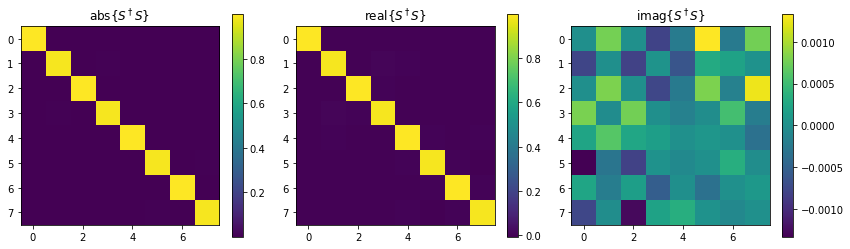

In [19]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(12, 3.5))
imabs = ax1.imshow(abs(mat))
imreal = ax2.imshow(mat.real)
imimag = ax3.imshow(mat.imag)
plt.colorbar(imabs, ax=ax1)
plt.colorbar(imreal, ax=ax2)
plt.colorbar(imimag, ax=ax3)
ax1.set_title('abs{$S^\dagger S$}')
ax2.set_title('real{$S^\dagger S$}')
ax3.set_title('imag{$S^\dagger S$}')
plt.show()

It looks pretty close, but there seems to indeed be a bit of loss (expected).

## Viewing individual Simulation Data
To verify, we may want to take a look the individual simulation data.
For that, we can load up the batch and inspect the [SimulationData](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.Simulation.html) for each task.

In [20]:
batch_data = modeler.batch.load(path_dir='data')

[16:25:56] INFO     loading SimulationData from                                 ]8;id=743811;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=595907;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#398\398]8;;\
                    data/5bc5306b-1439-439a-8584-38e8f7c01fcc.hdf5                           

[16:25:59] INFO     loading SimulationData from                                 ]8;id=298344;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=527293;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#398\398]8;;\
                    data/324b3fa4-516e-41da-bc99-706c4d5ad8ae.hdf5                           

<Figure size 1080x720 with 4 Axes>

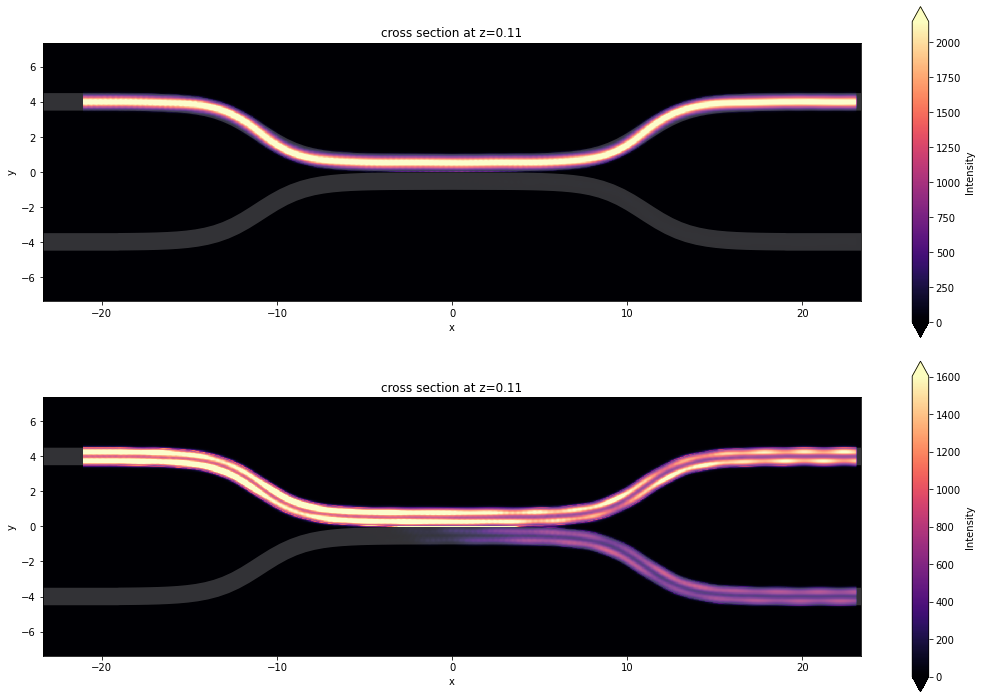

In [21]:
f, (ax1, ax2) = plt.subplots(2, 1, tight_layout=True, figsize=(15, 10))
ax1 = batch_data['smatrix_portleft_top_mode0'].plot_field('field', 'int', freq=freq0, z=wg_height/2, ax=ax1)
ax2 = batch_data['smatrix_portleft_top_mode1'].plot_field('field', 'int', freq=freq0, z=wg_height/2, ax=ax2)